In [178]:
import sys
sys.path.append('..')
from spyral_utils.plot import CutHandler, serialize_cut, Histogrammer
from spyral_utils.nuclear import NuclearDataMap
from spyral.core.workspace import Workspace
from spyral.core.config import load_config
from spyral.core.constants import DEG2RAD
from spyral.core.particle_id import load_particle_id

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from pathlib import Path
from json import load, dump

%matplotlib widget

RAD2DEG = 1.0/DEG2RAD

In [179]:
config = load_config(Path("D:\\e20009_pc\\e20009_config.json"))
ws = Workspace(config.workspace)
nuclear_map = NuclearDataMap()

In [180]:
grammer = Histogrammer()
handler = CutHandler()

grammer.add_hist2d("particle_id", (400, 400), ((-10.0, 15e3), (-0.1, 1.5))) # Plot of dEdx vs. Brho (particle ID)
grammer.add_hist1d("ion_chamber", 4096, (0.0, 4096.0)) # Plot of ion chamber (beam ID)
grammer.add_hist2d("kinematics", (720, 400), ((0.0, 180.0), (0.0, 3.0))) # Plot of polar angle vs. Brho (kinematics)

In [181]:
run_min = 270
run_max = 279

for run in range(run_min, run_max+1):
    run_path = ws.get_estimate_file_path_parquet(run)
    if not run_path.exists():
        continue
    df = pl.read_parquet(run_path)
    # The below filter is optional. Filter the data on the ion chamber gate. Comment/Uncomment the line below to turn on/off the filter
    df = df.filter((pl.col('ic_amplitude') > config.solver.ic_min_val) & (pl.col('ic_amplitude') < config.solver.ic_max_val))
    grammer.fill_hist2d('particle_id', df.select('dEdx').to_numpy(), df.select('brho').to_numpy())
    grammer.fill_hist2d('kinematics', df.select('polar').to_numpy() * RAD2DEG, df.select('brho').to_numpy())
    grammer.fill_hist1d('ion_chamber', df.unique(subset=['event']).select('ic_amplitude').to_numpy())

In [182]:
pid_path = ws.get_gate_file_path(config.solver.particle_id_filename)
with open(pid_path, "r") as pid_file:
    cut_json =  load(pid_file)

#vertices = np.asarray(cut_json['vertices'])
x =[]
y = []
for point, coords in enumerate(cut_json['vertices']):
    x.append(coords[0]/1.5)
    y.append(coords[1])

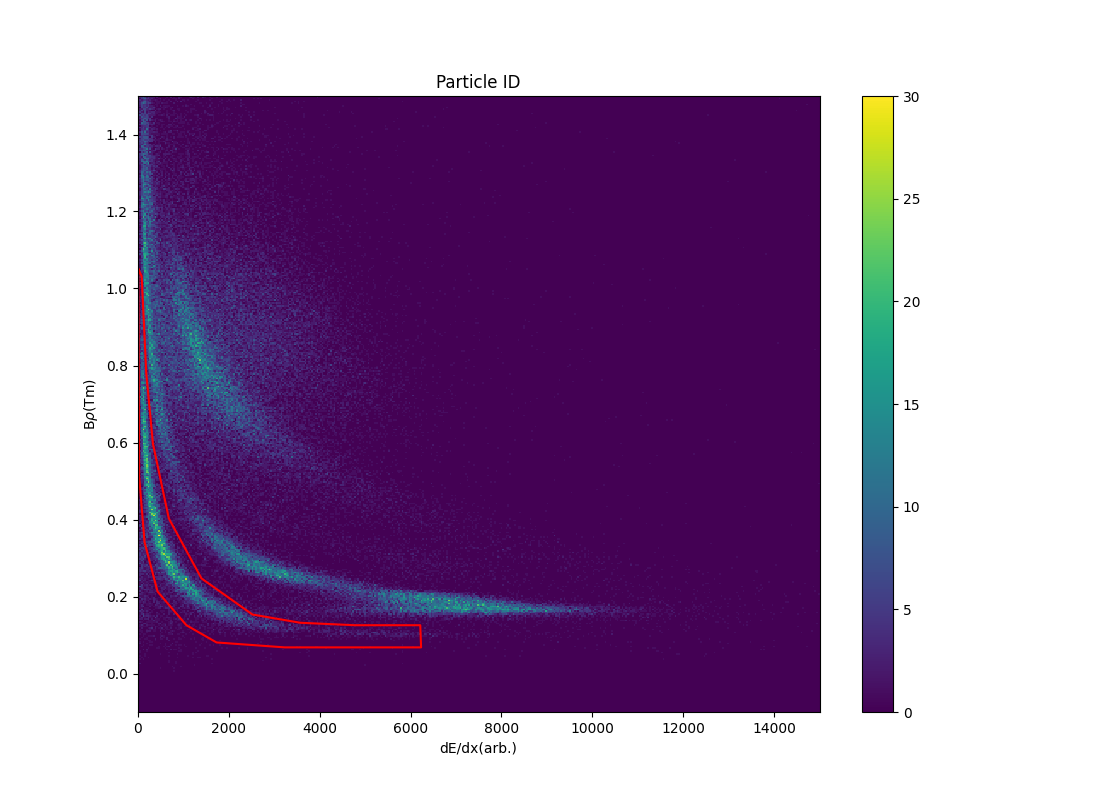

In [183]:
pid_hist = grammer.get_hist2d("particle_id")
fig, ax = plt.subplots(1,1)
mesh = ax.pcolormesh(pid_hist.x_bins, pid_hist.y_bins, pid_hist.counts)
fig.colorbar(mesh, ax=ax)
ax.plot(x, y, color = 'red')
ax.set_title("Particle ID")
ax.set_xlabel("dE/dx(arb.)")
ax.set_ylabel("B$\\rho$(Tm)")
fig.set_figheight(8.0)
fig.set_figwidth(11.0)